## Identification of multi labeled brand and color of car using dataset-https://www.kaggle.com/datasets/julichitai/multilabel-small-car-and-color-dataset

Importing kaggle and connecting dataset via API command.

In [1]:
import kaggle

OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.

In [2]:
!mv kaggle.json /root/.kaggle

In [3]:
import kaggle

In [4]:
!kaggle datasets download -d julichitai/multilabel-small-car-and-color-dataset

 98% 237M/241M [00:11<00:00, 21.5MB/s]
100% 241M/241M [00:11<00:00, 22.9MB/s]


In [5]:
!unzip -q /content/multilabel-small-car-and-color-dataset.zip -d data/

Importing libraries

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import cv2
import os
import random

Image Agumentation and Prerocessing by Image Data Generator.<br>
This is required to make the image fit for our model.

In [7]:
idg = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.1, rotation_range= 30,
                                                      width_shift_range=0.2, height_shift_range=0.2,
                                                      brightness_range=(0.8,1.2),
                                                      zoom_range=(0.8,1.2), horizontal_flip=True,)

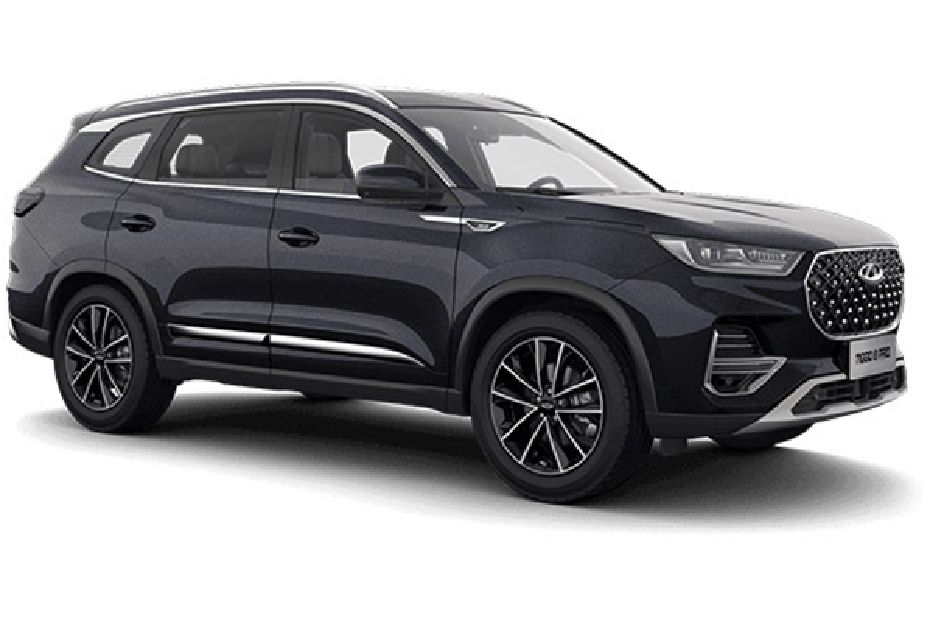

In [10]:
tf.keras.preprocessing.image.load_img('/content/data/tiggo black/000004.jpg')

Calculation the Mean & median of all images.

In [17]:
car_model = os.listdir('data')

In [21]:
car_model_dir = {}
for i in car_model:
  car_model_dir[i] = os.listdir(f'data/{i}')

In [37]:
shape = []
for i in car_model_dir:
  for j in car_model_dir[i]:
    shape.append(tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(f'/content/data/{i}/{j}')).shape)

In [44]:
np.array(shape).mean(axis=0)

array([472.94040219, 686.31042048,   3.        ])

In [46]:
np.median(np.array(shape),axis=0)

array([320., 480.,   3.])

Creating Train & Validation set for the model.<br>
Since we have seen that there is much difference bwteen mean & median shapes of images, considering median as a best measure for all images.

In [49]:
batch_size = 32

In [51]:
train_idg = idg.flow_from_directory('/content/data',target_size=(320, 480), batch_size = batch_size,
                                    shuffle=True, subset='training')

Found 2465 images belonging to 9 classes.


In [87]:
val_idg = idg.flow_from_directory('/content/data',target_size=(320, 480), batch_size = batch_size,
                                    shuffle=False, subset='validation')

Found 270 images belonging to 9 classes.


In [52]:
ind = {values: key for key,values in train_idg.class_indices.items()}
ind

{0: 'matiz black',
 1: 'matiz blue',
 2: 'matiz red',
 3: 'rio black',
 4: 'rio blue',
 5: 'rio red',
 6: 'tiggo black',
 7: 'tiggo blue',
 8: 'tiggo red'}

Creating a model by ensembling VGG, Mobilenet and Resent weights and adding 2 Hidden layes with Relu as an activation function & Softmax for Output layer.

In [53]:
input = tf.keras.layers.Input((320, 480,3), name='Input_Layer')

vgg_pp =  tf.keras.layers.Lambda(tf.keras.applications.vgg16.preprocess_input, output_shape = (320, 480,3), name= "VGG_Preprocess") (input)
vgg_model = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=(320, 480,3))
vgg_model.trainable = False
vgg = vgg_model (vgg_pp)
vgg_bn = tf.keras.layers.BatchNormalization(name = 'VGG_BN') (vgg)
vgg_gap  = tf.keras.layers.GlobalAveragePooling2D(name='VGG_GAP') (vgg_bn)

resnet_pp = tf.keras.layers.Lambda(tf.keras.applications.resnet_v2.preprocess_input, output_shape = (320, 480,3), name = 'Resnet_Prerpocess') (input)
resnet_model = tf.keras.applications.ResNet50V2(include_top=False, input_shape=(320, 480,3))
resnet_model.trainable = False
resnet = resnet_model (resnet_pp)
resnet_bn = tf.keras.layers.BatchNormalization(name = 'Resnet_BN') (resnet)
resnet_gap =  tf.keras.layers.GlobalAveragePooling2D(name='Resnet_GAP') (resnet_bn)

mob_pp =  tf.keras.layers.Lambda(tf.keras.applications.mobilenet.preprocess_input, output_shape = (320, 480,3), name= "Mob_Preprocess") (input)
mob_model = tf.keras.applications.MobileNetV2(include_top=False,input_shape=(320, 480,3))
mob_model.trainable = False
mob = mob_model (mob_pp)
mob_bn = tf.keras.layers.BatchNormalization(name = 'Mob_BN') (mob)
mob_gap  = tf.keras.layers.GlobalAveragePooling2D(name='Mob_GAP') (mob_bn)

concat = tf.keras.layers.Concatenate(name='Concat') ([vgg_gap,mob_gap,resnet_gap])
dropout = tf.keras.layers.Dropout(0.3, name='Dropout') (concat)
dense1 = tf.keras.layers.Dense(1024, activation = 'relu', name = 'Hidden_Layer1') (dropout)
dense2 = tf.keras.layers.Dense(516, activation = 'relu', name = 'Hidden_Layer2') (dropout)
dense3 = tf.keras.layers.Dense(256, activation = 'relu', name = 'Hidden_Layer3')(dense2)
output = tf.keras.layers.Dense(9, activation= 'softmax', name='Output') (dense3)

94668760/94668760 [==============================] - 1s 0us/step


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# del model

In [57]:
# Defining a model, compilers, callbacks for the model and fitting the data.
model = tf.keras.models.Model(inputs=input, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.categorical_crossentropy,
              metrics = ['AUC'])
tf_mod_call = tf.keras.callbacks.ModelCheckpoint('Car_Identificaiton_Model',monitor='val_loss', save_best_only=True)
model.summary()
model.fit(train_idg, batch_size=batch_size, epochs = 20,validation_data=val_idg, callbacks=[tf_mod_call])

# Ploting model accuracy and loss.
plt.figure(figsize=(12,5))
plt.suptitle('Batch_size=32, (160X160),Adam LR=0.01')
plt.subplot(121)
plt.plot(model.history.history['auc'], label='accuracy')
plt.plot(model.history.history['val_auc'], label='val_accuracy')
plt.legend()
plt.subplot(122)
plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.legend()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_Layer (InputLayer)    [(None, 320, 480, 3)]        0         []                            
                                                                                                  
 VGG_Preprocess (Lambda)     (None, 320, 480, 3)          0         ['Input_Layer[0][0]']         
                                                                                                  
 Mob_Preprocess (Lambda)     (None, 320, 480, 3)          0         ['Input_Layer[0][0]']         
                                                                                                  
 Resnet_Prerpocess (Lambda)  (None, 320, 480, 3)          0         ['Input_Layer[0][0]']         
                                                                                            

KeyboardInterrupt: 

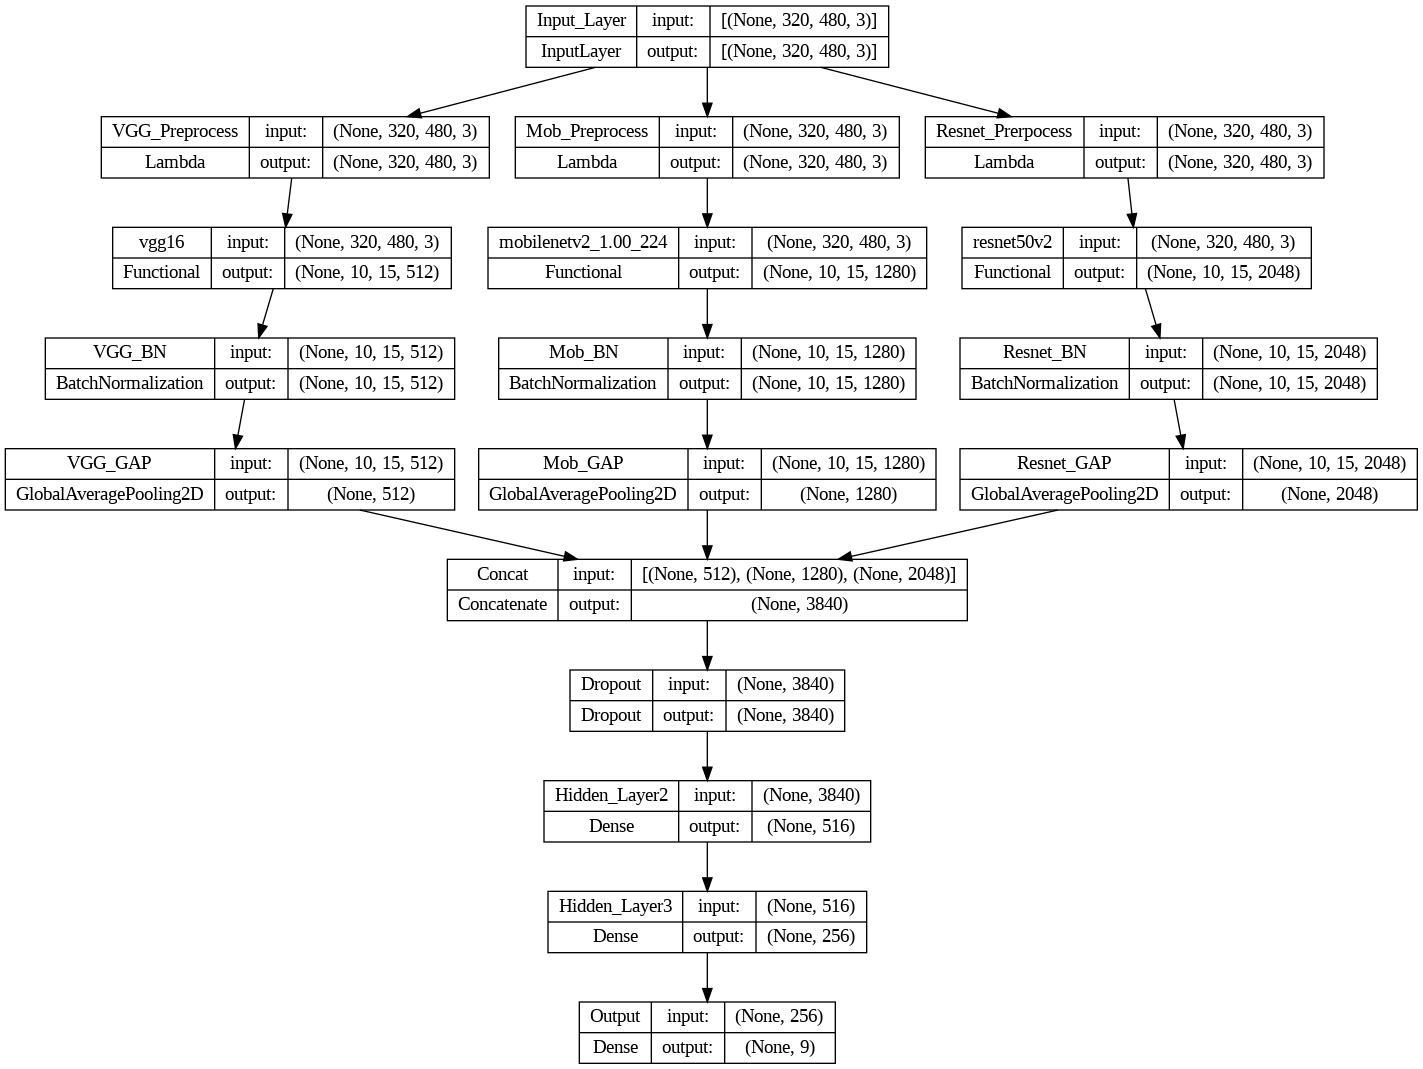

In [58]:
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True)

Using best model saved by the callback fuction as our final model.

In [59]:
final_model = tf.keras.models.load_model('/content/Car_Identificaiton_Model')

Lets save our final model for future use in keras format.

In [ ]:
tf.keras.models.save_model(final_model,"Car_Identificaiton_Model.keras")

For loading a model.

In [ ]:
# final_model = tf.keras.models.load_model("/content/Car_Identificaiton_Model.keras",safe_mode=False)

Checking the accuracy of the model on completed dataset.

In [93]:
result_val = final_model.predict(val_idg)
result_val_argmax = np.argmax(result_val, axis=1)
y_true = val_idg.labels
y_pred = result_val_argmax
(y_pred == y_true).mean()

9/9 [==============================] - 15s 2s/step


0.8814814814814815

In [94]:
from sklearn.metrics import confusion_matrix, classification_report

In [95]:
# confusion_matrix(y_true,y_pred)

In [96]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.61      0.72        23
           1       1.00      0.94      0.97        33
           2       0.89      1.00      0.94        34
           3       0.71      0.90      0.79        30
           4       0.88      0.88      0.88        26
           5       1.00      0.91      0.95        43
           6       0.85      0.79      0.81        28
           7       0.80      0.89      0.84        27
           8       0.92      0.92      0.92        26

    accuracy                           0.88       270
   macro avg       0.88      0.87      0.87       270
weighted avg       0.89      0.88      0.88       270



Lets test the model with any open source image of car having relevant model and colour.

--2024-02-29 14:14:02--  https://i.ytimg.com/vi/dy2unhVFBKo/maxresdefault.jpg
Resolving i.ytimg.com (i.ytimg.com)... 142.251.2.119, 2607:f8b0:4023:c0d::77
Connecting to i.ytimg.com (i.ytimg.com)|142.251.2.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 193669 (189K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>] 189.13K  --.-KB/s    in 0.001s  

2024-02-29 14:14:02 (134 MB/s) - ‘test.jpg’ saved [193669/193669]



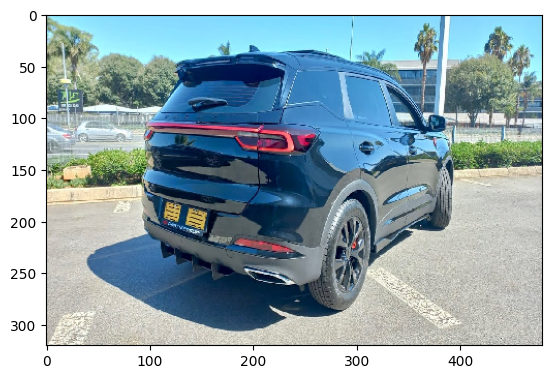

1/1 [==============================] - 2s 2s/step
tiggo blue [88.62076]
tiggo black [10.703225]
rio black [0.3209097]
rio blue [0.2134802]


In [100]:
!wget -O test.jpg https://i.ytimg.com/vi/dy2unhVFBKo/maxresdefault.jpg

image = tf.keras.preprocessing.image.load_img('test.jpg', target_size=(320, 480))
image = tf.keras.preprocessing.image.img_to_array(image)
plt.imshow(image.astype('int'))
plt.show()
image = np.expand_dims(image, axis=0)
result = final_model.predict(image)
data = train_idg.class_indices
for i in list(np.argsort(result)[:,:-5:-1][0]):
  print(list(data.keys())[i],result[:,i]*100)

Testing the model on randomly selected data from the directory

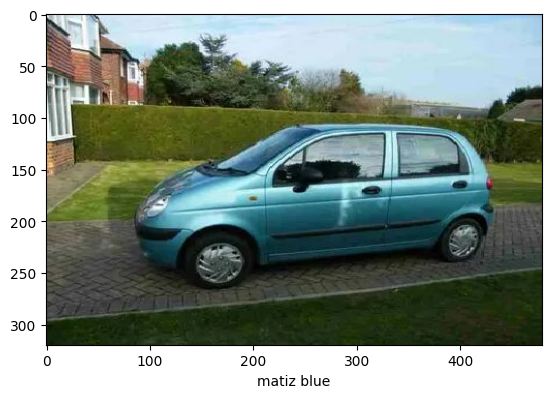

1/1 [==============================] - 0s 40ms/step
matiz blue [97.27313]
matiz black [2.458173]
matiz red [0.25970697]
tiggo black [0.00591496]


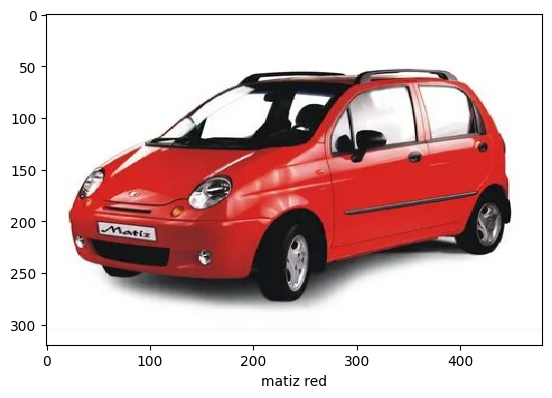

1/1 [==============================] - 0s 46ms/step
matiz red [99.99947]
matiz blue [0.00049423]
matiz black [2.6711075e-05]
rio red [2.0549182e-06]


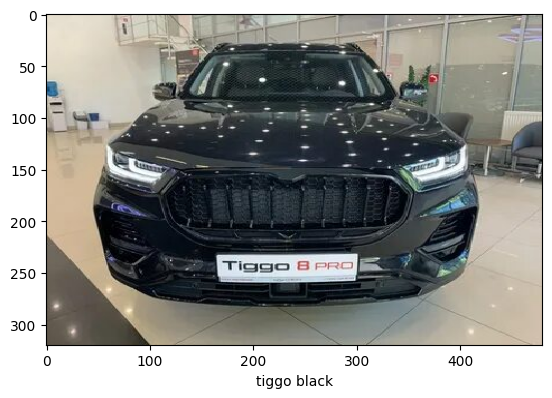

1/1 [==============================] - 0s 30ms/step
tiggo blue [75.2538]
tiggo black [24.30431]
rio black [0.2842464]
rio blue [0.09271955]


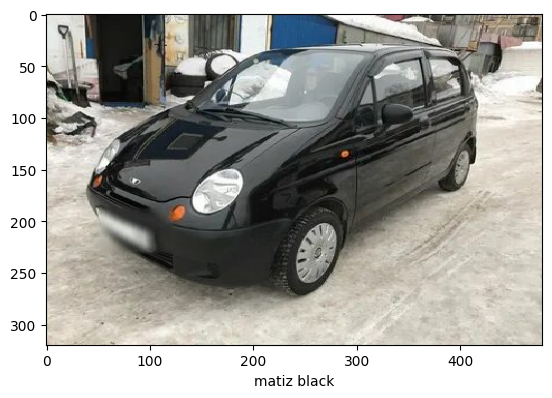

1/1 [==============================] - 0s 37ms/step
matiz black [99.97195]
rio black [0.01832704]
tiggo black [0.00708584]
matiz blue [0.00235049]


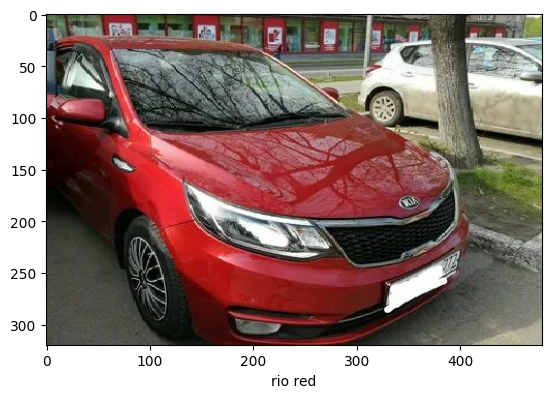

1/1 [==============================] - 0s 45ms/step
rio red [99.9373]
tiggo red [0.04216829]
matiz red [0.02038522]
rio blue [7.795737e-05]


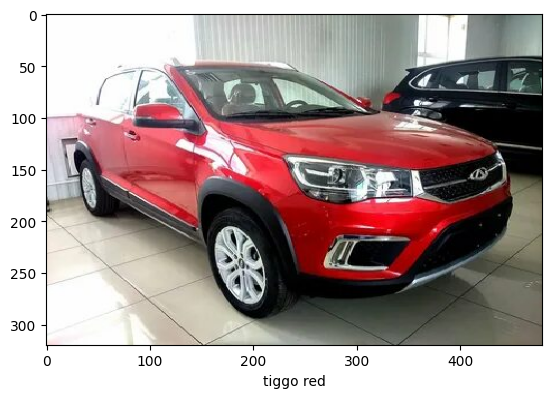

1/1 [==============================] - 0s 52ms/step
tiggo red [99.50564]
rio red [0.45975015]
tiggo black [0.03375168]
tiggo blue [0.00041275]


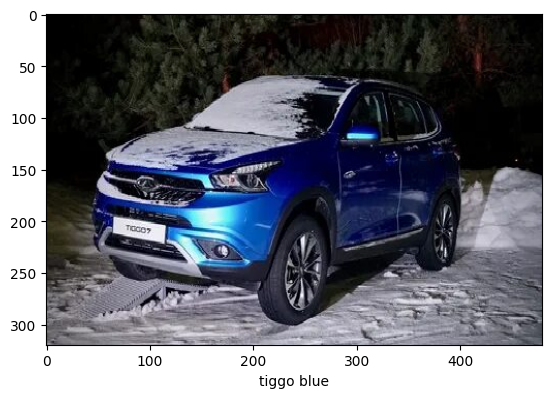

1/1 [==============================] - 0s 70ms/step
tiggo blue [99.85257]
tiggo black [0.13982889]
tiggo red [0.00647427]
rio blue [0.00099644]


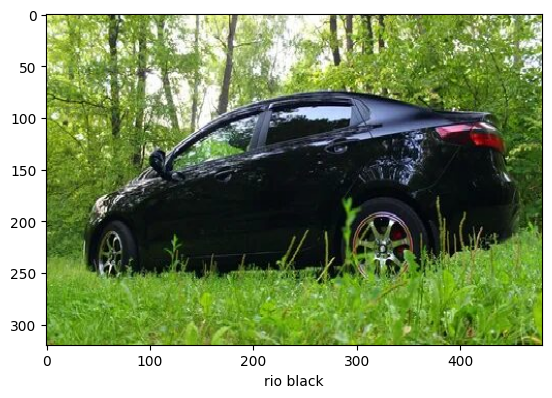

1/1 [==============================] - 0s 53ms/step
rio black [98.18179]
tiggo black [1.7651718]
matiz black [0.0510172]
rio blue [0.00162087]


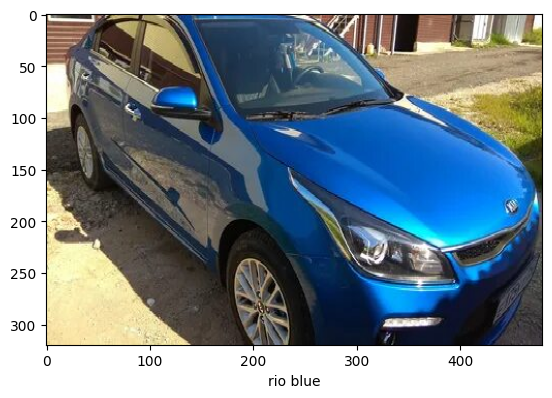

1/1 [==============================] - 0s 72ms/step
rio blue [99.985596]
tiggo blue [0.00816233]
matiz blue [0.00389798]
rio black [0.00199693]


In [118]:
y_true = []
y_pred = []
for i in range(len(car_model)):
  image = tf.keras.preprocessing.image.load_img(f'/content/data/{car_model[i]}/{random.choice(car_model_dir[car_model[i]])}', target_size=(320, 480))
  image = tf.keras.preprocessing.image.img_to_array(image)
  plt.imshow(image.astype('int'))
  plt.xlabel(car_model[i].split(".")[0])
  y_true.append(car_model[i].split(".")[0])
  plt.show()
  image = np.expand_dims(image, axis=0)
  result = final_model.predict(image)
  y_pred.append({v: k for k, v in train_idg.class_indices.items()}[np.argsort(result[0])[-1]])
  data = train_idg.class_indices
  for j in np.argsort(result[0])[:-5:-1]:
    print({v: k for k, v in train_idg.class_indices.items()}[j],result[:,j]*100)

Saving the results in a dataframe

In [122]:
result = pd.DataFrame({"y_true":y_true,'y_pred':y_pred})

In [123]:
len(result[(result['y_true']==result['y_pred'])])/len(result)*100

88.88888888888889

Searching for the wrong identificaiton

In [130]:
result[(result['y_true']!=result['y_pred'])]

y_true      y_pred
2  tiggo black  tiggo blue

In [129]:
result

y_true       y_pred
0   matiz blue   matiz blue
1    matiz red    matiz red
2  tiggo black   tiggo blue
3  matiz black  matiz black
4      rio red      rio red
5    tiggo red    tiggo red
6   tiggo blue   tiggo blue
7    rio black    rio black
8     rio blue     rio blue